In [1]:
import os 

os.chdir("/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/")

import collections
import IPython

if IPython.get_ipython() is not None:
    IPython.get_ipython().run_line_magic("load_ext", "autoreload")  # type: ignore
    IPython.get_ipython().run_line_magic("autoreload", "2")  # type: ignore

from copy import deepcopy
from subnetwork_probing.train import iterative_correspondence_from_mask
from acdc.acdc_utils import filter_nodes, get_edge_stats, get_node_stats, get_present_nodes, reset_network
import pandas as pd
import gc
import math
import sys
import re
from typing import (
    List,
    Tuple,
    Dict,
    Any,
    Optional,
    Union,
    Callable,
    TypeVar,
    Iterable,
    Set,
)
import requests
from acdc.TLACDCInterpNode import parse_interpnode, heads_to_nodes_to_mask
import pickle
import wandb
import IPython
from tqdm import tqdm
import random
from functools import partial
import json
import pathlib
import warnings
import time
import networkx as nx
import os
import torch
import huggingface_hub
import pygraphviz as pgv
from enum import Enum
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
from acdc.acdc_utils import (
    make_nd_dict,
    shuffle_tensor,
    cleanup,
    ct,
)

from acdc.TLACDCEdge import (
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from collections import defaultdict, deque, OrderedDict
from acdc.acdc_utils import (
    kl_divergence,
)

from acdc.acdc_graphics import (
    build_colorscheme,
    get_node_name,
    show,
)

from acdc.hybridretrieval.utils import ( 
    get_all_hybrid_retrieval_things,
    get_gpt2_small
)

import argparse
from pathlib import Path

def get_col(df, col): # dumb util
    non_null_entries = list(df.loc[df[col].notnull(), col])
    return non_null_entries 

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import IPython
# from roc_plot_generator import get_acdc_runs, plot_roc_curve

parser = argparse.ArgumentParser(description="Used to control ROC plot scripts (for standardisation with other files...)")
parser.add_argument('--task', type=str, required=True, choices=['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan', 'hybrid-retrieval'], help='Choose a task from the available options: ioi, docstring, induction, tracr-reverse, tracr-proportion, greaterthan')
parser.add_argument("--mode", type=str, required=False, choices=["edges", "nodes"], help="Choose a mode from the available options: edges, nodes", default="edges") # TODO implement nodes
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument("--alg", type=str, default="none", choices=["none", "acdc", "sp", "16h", "canonical"])
parser.add_argument("--skip-sixteen-heads", action="store_true", help="Skip the 16 heads stuff")
parser.add_argument("--skip-sp", action="store_true", help="Skip the SP stuff")
parser.add_argument("--testing", action="store_true", help="Use testing data instead of validation data")
parser.add_argument("--device", type=str, default="cpu")
parser.add_argument("--out-dir", type=str, default="DEFAULT")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=42, help="Random seed")
parser.add_argument("--canonical-graph-save-dir", type=str, default="DEFAULT")
parser.add_argument("--only-save-canonical", action="store_true", help="Only save the canonical graph")
parser.add_argument("--ignore-missing-score", action="store_true", help="Ignore runs that are missing score")


ipython = IPython.get_ipython()
if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""--task=hybrid-retrieval\
--task=hybrid-retrieval\
--metric=kl_div\
--device=cuda\
--reset-network=0\
--alg=acdc""".split("\\\n")]
    )
if not args.mode == "edges":
    raise NotImplementedError("Only edges mode is implemented for now")


if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
METRIC = args.metric
DEVICE = args.device
ZERO_ABLATION = True if args.zero_ablation else False
RESET_NETWORK = 1 if args.reset_network else 0
SKIP_ACDC = False
SKIP_SP = True if args.skip_sp else False
SKIP_SIXTEEN_HEADS = True if args.skip_sixteen_heads else False
SKIP_CANONICAL = False
TESTING = True if args.testing else False
ONLY_SAVE_CANONICAL = True if args.only_save_canonical else False

In [3]:
__file__ = "/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/hybridretrieval/roc/roc_plot_generator.py"
if args.out_dir == "DEFAULT":
    OUT_DIR = Path(__file__).resolve().parent / "roc_plots" / "plots_data"
    CANONICAL_OUT_DIR = Path(__file__).resolve().parent / "results" / "canonical_circuits"
else:
    OUT_DIR = Path(args.out_dir)
    CANONICAL_OUT_DIR = Path(args.canonical_graph_save_dir)
CANONICAL_OUT_DIR.mkdir(exist_ok=True, parents=True)

In [4]:
if args.alg != "none":
    SKIP_ACDC = False if args.alg == "acdc" else True
    SKIP_SP = False if args.alg == "sp" else True
    SKIP_SIXTEEN_HEADS = False if args.alg == "16h" else True
    SKIP_CANONICAL = False if args.alg == "canonical" else True
    OUT_FILE = OUT_DIR / f"{args.alg}-{args.task}-{args.metric}-{args.zero_ablation}-{args.reset_network}.json"

    if OUT_FILE.exists():
        print("File already exists, skipping")
        # sys.exit(0)
else:
    OUT_FILE = None

File already exists, skipping


In [5]:
if TASK == "hybrid-retrieval":
    num_examples = 20
    things = get_all_hybrid_retrieval_things(num_examples, DEVICE, METRIC, True)

else:
    raise NotImplementedError("TODO " + TASK)

if RESET_NETWORK:
    reset_network(TASK, DEVICE, things.tl_model)
    gc.collect()
    torch.cuda.empty_cache()

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
Clean Prompts:
Alice lives in France, Paris - Alice, John lives in Germany, Berlin - John, Peter lives in USA, Washington - Peter
Lucy lives in Turkey, Ankara - Lucy, Sara lives in Italy, Rome - Sara, Bob lives in Spain, Madrid - Bob
Tom lives in Canada, Toronto - Tom, Anna lives in Australia, Canberra - Anna, Michael lives in Japan, Tokyo - Michael
David lives in Brazil, Rio de Janeiro - David, Alice lives in France, Paris - Alice, Peter lives in Germany, Berlin - Peter
Sara lives in USA, Washington - Sara, Lucy lives in Turkey, Ankara - Lucy, Tom lives in Italy, Rome - Tom
John lives in Spain, Madrid - John, Michael lives in Canada, Toronto - Michael, Anna lives in Australia, Canberra - Anna
David lives in Japan, Tokyo - David, Sara lives in Brazil, Rio de Janeiro - Sara, Alice lives in France, Paris - Alice
Bob lives in Germany, Berlin - Bob, Peter lives in USA, Washington - Peter, Tom lives in Turkey,

In [6]:
import gc
gc.collect()
torch.cuda.empty_cache()

USE_POS_EMBED = False

things.tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=things.tl_model,
    threshold=0.05,
    early_exit=SKIP_ACDC and SKIP_CANONICAL,
    using_wandb=False,
    zero_ablation=bool(ZERO_ABLATION),
    # Process very little data if just building the canonical graph
    ds=things.test_data[slice(1) if ONLY_SAVE_CANONICAL else slice(None)],
    ref_ds=things.test_patch_data[slice(1) if ONLY_SAVE_CANONICAL else slice(None)],
    metric=things.validation_metric,
    second_metric=None,
    verbose=True,
    use_pos_embed=USE_POS_EMBED,
    online_cache_cpu=False,
    corrupted_cache_cpu=False,
)
if not SKIP_ACDC and not ONLY_SAVE_CANONICAL:
    exp.setup_corrupted_cache()

max_subgraph_size = exp.corr.count_no_edges()

dict_keys(['blocks.11.hook_resid_post', 'blocks.11.hook_mlp_out', 'blocks.11.hook_mlp_in', 'blocks.11.attn.hook_result', 'blocks.11.attn.hook_q', 'blocks.11.hook_q_input', 'blocks.11.attn.hook_k', 'blocks.11.hook_k_input', 'blocks.11.attn.hook_v', 'blocks.11.hook_v_input', 'blocks.10.hook_mlp_out', 'blocks.10.hook_mlp_in', 'blocks.10.attn.hook_result', 'blocks.10.attn.hook_q', 'blocks.10.hook_q_input', 'blocks.10.attn.hook_k', 'blocks.10.hook_k_input', 'blocks.10.attn.hook_v', 'blocks.10.hook_v_input', 'blocks.9.hook_mlp_out', 'blocks.9.hook_mlp_in', 'blocks.9.attn.hook_result', 'blocks.9.attn.hook_q', 'blocks.9.hook_q_input', 'blocks.9.attn.hook_k', 'blocks.9.hook_k_input', 'blocks.9.attn.hook_v', 'blocks.9.hook_v_input', 'blocks.8.hook_mlp_out', 'blocks.8.hook_mlp_in', 'blocks.8.attn.hook_result', 'blocks.8.attn.hook_q', 'blocks.8.hook_q_input', 'blocks.8.attn.hook_k', 'blocks.8.hook_k_input', 'blocks.8.attn.hook_v', 'blocks.8.hook_v_input', 'blocks.7.hook_mlp_out', 'blocks.7.hook_ml

No edge 32923
Adding sender hooks...
Done corrupting things


In [7]:
CIRCUIT = {
    # These are the defined layers and heads for the new task based on your diagram and given task prompt
    "PEOPLE_LOC": [(0, 2), (0, 6), (1, 10)],  # Example nodes for people and locations
    "INFO": [(0, 4), (1, 1)],  # Example nodes for the information extracted
    "EARLY": [(0, None), (1, None), (2, None), (3, None)],
    "MID": [(5, 3), (6, 2), (7, 8), (8, 10), (9, 7)],
    "LATE": [(10, None), (11, None)],
}

GROUP_COLORS = {
    "PEOPLE_LOC": "#d7f8ee",
    "INFO": "#e7f2da",
    "EARLY": "#fee7d5",
    "MID": "#ececf5",
}

MLP_COLOR = "#f0f0f0"

def greaterthan_group_colorscheme():
    assert set(GROUP_COLORS.keys()) == set(CIRCUIT.keys())

    scheme = {
        "embed": "#cbd5e8",
        "<resid_post>": "#fff2ae",
    }

    for i in range(12):
        scheme[f"<m{i}>"] = MLP_COLOR

    for k, heads in CIRCUIT.items():
        for (layer, head) in heads:
            if head is None:
                scheme[f"<m{layer}>"] = GROUP_COLORS[k]
            else:
                for qkv in ["", "_q", "_k", "_v"]:
                    scheme[f"<a{layer}.{head}{qkv}>"] = GROUP_COLORS[k]
    return scheme

In [8]:
@dataclass(frozen=True)
class Conn:
    inp: str
    out: str
    qkv: tuple[str, ...]

def get_kbicr_true_edges(model):
    all_groups_of_nodes = [group for _, group in CIRCUIT.items()]
    all_nodes = [node for group in all_groups_of_nodes for node in group]
    assert len(all_nodes) == 16, len(all_nodes)

    nodes_to_mask = [
        TLACDCInterpNode(
            name=f"blocks.{layer_idx}.attn.hook_{letter}",
            index=TorchIndex([None, None, head_idx]),
            incoming_edge_type=EdgeType.DIRECT_COMPUTATION
        )
        for layer_idx in range(12)
        for head_idx in range(12)
        if (layer_idx, head_idx) not in all_nodes
        for letter in "qkv"
    ]

    from subnetwork_probing.train import iterative_correspondence_from_mask
    corr, _ = iterative_correspondence_from_mask(nodes_to_mask=nodes_to_mask, model=model)

    for layer_idx, head_idx in all_nodes:
        for letter in "qkv":
            edge_key = f"blocks.{layer_idx}.hook_{letter}_input"
            torch_index = TorchIndex([None, None, head_idx])
            if torch_index in corr.edges[edge_key]:
                edge_to = corr.edges[edge_key][torch_index]

                # Check and set presence of keys
                pre_key = f"blocks.0.hook_resid_pre"
                if TorchIndex([None]) in edge_to:
                    edge_to[pre_key][TorchIndex([None])].present = False

                for layer_from in range(layer_idx):
                    for head_from in range(12):
                        result_key = f"blocks.{layer_from}.attn.hook_result"
                        if TorchIndex([None, None, head_from]) in edge_to:
                            edge_to[result_key][TorchIndex([None, None, head_from])].present = False

                post_key = "blocks.11.hook_resid_post"
                result_key = f"blocks.{layer_idx}.attn.hook_result"
                if TorchIndex([None]) in corr.edges[post_key]:
                    corr.edges[post_key][TorchIndex([None])][result_key][torch_index].present = False

    return OrderedDict({
        (t[0], t[1].hashable_tuple, t[2], t[3].hashable_tuple): e.present
        for t, e in corr.all_edges().items() if e.present
    })

In [9]:
COLORSCHEME_FOR = collections.defaultdict(lambda: (lambda: "Pastel2"), {
    # "ioi": ioi_group_colorscheme,
    # "greaterthan": greaterthan_group_colorscheme,
    'hybridretrieval': greaterthan_group_colorscheme,
})

get_true_edges = partial(get_kbicr_true_edges, model=things.tl_model)

if TASK != "induction":
    d = {(d[0], d[1].hashable_tuple, d[2], d[3].hashable_tuple): False for d in exp.corr.all_edges()}
    d_trues = get_true_edges()
    # if ONLY_SAVE_CANONICAL and TASK == "ioi":
    #     # Remove non-adjacent layer connections
    #     def layer(name):
    #         return int(name.split(".")[1])

    #     for t in list(d_trues.keys()):
    #         if abs(layer(t[0]) - layer(t[2])) > 1:
    #             del d_trues[t]

    for k in d_trues:
        d[k] = True

    exp.load_subgraph(d)
    canonical_circuit_subgraph = deepcopy(exp.corr)
    for t in exp.corr.all_edges().keys():
        exp.corr.edges[t[0]][t[1]][t[2]][t[3]].present = True
    canonical_circuit_subgraph_size = canonical_circuit_subgraph.count_no_edges()

    # and reset the sugbgraph...
    for t, e in exp.corr.all_edges().items():
        exp.corr.edges[t[0]][t[1]][t[2]][t[3]].present = True

    for edge in canonical_circuit_subgraph.all_edges().values():
        edge.effect_size = 1.0  # make it visible

    if ONLY_SAVE_CANONICAL:
        colorscheme = COLORSCHEME_FOR[TASK]()
        g: pgv.AGraph = show(
            canonical_circuit_subgraph,
            fname=CANONICAL_OUT_DIR / f"{TASK}.gv",
            colorscheme=colorscheme,
            show_full_index=False,
            layout="neato" if TASK in ["ioi", "greaterthan"] else "dot",
        )

        show(
            canonical_circuit_subgraph,
            fname=CANONICAL_OUT_DIR / f"{TASK}_mlp.gv",
            colorscheme=colorscheme,
            show_full_index=False,
            remove_qkv=True,
        )

        if TASK in ["ioi", "greaterthan", "hybrid-retrieval"]:
            no_mlp = deepcopy(canonical_circuit_subgraph)
            for (n_to, _, n_from, _), e in no_mlp.all_edges().items():
                if "mlp" in n_to or "mlp" in n_from:
                    e.present = False
            show(
                no_mlp,
                fname=CANONICAL_OUT_DIR / f"{TASK}_heads_qkv.gv",
                colorscheme=colorscheme,
                show_full_index=False,
                remove_self_loops=True,
                remove_qkv=False,
                layout="dot",
            )
            show(
                no_mlp,
                fname=CANONICAL_OUT_DIR / f"{TASK}_heads.gv",
                colorscheme=colorscheme,
                show_full_index=False,
                remove_self_loops=True,
                remove_qkv=True,
                layout="dot",
            )

if ONLY_SAVE_CANONICAL:
    sys.exit(0)

Editing all edges...
Done!


In [10]:
@dataclass(frozen=True)
class AcdcRunCandidate:
    threshold: float
    steps: int
    run: str
    score_d: dict
    corr: TLACDCCorrespondence

In [11]:
# import json
# import os
# from collections import defaultdict
# from dataclasses import dataclass
# from typing import Any, Callable, Optional, Dict
# from tqdm import tqdm
# from copy import deepcopy
# import torch

# @dataclass(frozen=True)
# class AcdcRunCandidate:
#     threshold: float
#     steps: int
#     score_d: dict
#     corr: TLACDCCorrespondence  

# def get_acdc_runs(
#     exp,
#     project_path: str,  # Local path to the project directory
#     pre_run_filter: Optional[Callable[[str], bool]] = None,
#     run_filter: Optional[Callable[[Dict[str, Any]], bool]] = None,
#     clip: Optional[int] = None,
#     return_ids: bool = False,
# ):
#     if clip is None:
#         clip = 100_000

#     # List all run directories, excluding known non-run directories like 'logs'
#     run_dirs = [d for d in os.listdir(project_path) if os.path.isdir(os.path.join(project_path, d)) and d != 'logs']
    
#     if pre_run_filter is not None:
#         run_dirs = list(filter(pre_run_filter, run_dirs))

#     if run_filter is None:
#         filtered_run_dirs = run_dirs[:clip]
#     else:
#         filtered_run_dirs = list(filter(run_filter, tqdm(run_dirs[:clip])))

#     print(f"Loading {len(filtered_run_dirs)} runs with filter {pre_run_filter} and {run_filter}")

#     threshold_to_run_map: Dict[float, AcdcRunCandidate] = {}

#     def add_run_for_processing(candidate: AcdcRunCandidate):
#         if candidate.threshold not in threshold_to_run_map:
#             threshold_to_run_map[candidate.threshold] = candidate
#         else:
#             if candidate.steps > threshold_to_run_map[candidate.threshold].steps:
#                 threshold_to_run_map[candidate.threshold] = candidate

#     for run_dir in filtered_run_dirs:
#         # run_path = os.path.join(project_path, run_dir)
#         metrics_path = os.path.join(project_path, 'logs', 'metrics.json')
        
#         # Skip directories without the necessary files
#         if not os.path.exists(metrics_path):
#             print(f"Metrics file not found for run {run_dir}")
#             continue

#         try:
#             with open(metrics_path, 'r') as f:
#                 metrics_data = json.load(f)
#                 parents = metrics_data["list_of_parents_evaluated"]
#                 children = metrics_data["list_of_children_evaluated"]
#                 results = metrics_data["results"]
#                 steps = metrics_data.get("steps", [])
#         except KeyError:
#             print(f"Required keys not found in metrics file for run {run_dir}")
#             continue
#         try:
#             log_path = os.path.join(project_path, 'logs', 'log.txt')
#             with open(log_path) as f:
#                 log_file = f.read()
#             exp.load_from_local_run(log_file)
#         except FileNotFoundError:
#             print(f"Log file not found for run {run_dir}")
#             continue

#         threshold = 0.05  # Fixed threshold value
#         corr = deepcopy(exp.corr)

#         for parent, child, result in zip(parents, children, results):
#             parent_node = parse_interpnode(parent)
#             child_node = parse_interpnode(child)

#             if result < threshold:
#                 corr.edges[child_node.name][child_node.index][parent_node.name][parent_node.index].present = False
#                 corr.remove_edge(child_node.name, child_node.index, parent_node.name, parent_node.index)
#             else:
#                 corr.edges[child_node.name][child_node.index][parent_node.name][parent_node.index].present = True

#         # Use the number of steps in the results if available, otherwise default to length of results
#         num_steps = steps[-1] if steps else len(results)
#         score_d = {"steps": num_steps, "score": threshold}

#         candidate = AcdcRunCandidate(
#             threshold=threshold,
#             steps=num_steps,
#             score_d=score_d,
#             corr=corr
#         )
#         add_run_for_processing(candidate)
#         print(f"Added candidate: {candidate}")

#     # Added to handle the test functions
#     def all_test_fns(data: torch.Tensor) -> dict[str, float]:
#         return {f"test_{name}": fn(data).item() for name, fn in things.test_metrics.items()}

#     all_candidates = list(threshold_to_run_map.values())
#     for candidate in all_candidates:
#         test_metrics = exp.call_metric_with_corr(candidate.corr, all_test_fns, things.test_data)
#         candidate.score_d.update(test_metrics)
#         print(f"Added run with threshold={candidate.threshold}, n_edges={candidate.corr.count_no_edges()}")

#     corrs = [(candidate.corr, candidate.score_d) for candidate in all_candidates]
#     if return_ids:
#         return corrs, [candidate.threshold for candidate in all_candidates]  # Corrected to return threshold
#     return corrs

# This works!!!

In [12]:
# import json
# import os
# from collections import defaultdict
# from dataclasses import dataclass
# from typing import Any, Callable, Optional, Dict
# from tqdm import tqdm
# from copy import deepcopy
# import torch

# @dataclass(frozen=True)
# class AcdcRunCandidate:
#     threshold: float
#     steps: int
#     score_d: dict
#     corr: TLACDCCorrespondence  

# def get_acdc_runs(
#     exp,
#     project_path: str,  # Local path to the project directory
#     pre_run_filter: Optional[Callable[[str], bool]] = None,
#     run_filter: Optional[Callable[[Dict[str, Any]], bool]] = None,
#     clip: Optional[int] = None,
#     return_ids: bool = False,
# ):
#     if clip is None:
#         clip = 100_000

#     # List all run directories, excluding known non-run directories like 'logs'
#     run_dirs = [d for d in os.listdir(project_path) if os.path.isdir(os.path.join(project_path, d)) and d != 'logs']
    
#     if pre_run_filter is not None:
#         run_dirs = list(filter(pre_run_filter, run_dirs))

#     if run_filter is None:
#         filtered_run_dirs = run_dirs[:clip]
#     else:
#         filtered_run_dirs = list(filter(run_filter, tqdm(run_dirs[:clip])))

#     print(f"Loading {len(filtered_run_dirs)} runs with filter {pre_run_filter} and {run_filter}")

#     threshold_to_run_map: Dict[float, AcdcRunCandidate] = {}

#     def add_run_for_processing(candidate: AcdcRunCandidate):
#         if candidate.threshold not in threshold_to_run_map:
#             threshold_to_run_map[candidate.threshold] = candidate
#         else:
#             if candidate.steps > threshold_to_run_map[candidate.threshold].steps:
#                 threshold_to_run_map[candidate.threshold] = candidate

#     for run_dir in filtered_run_dirs:
#         # run_path = os.path.join(project_path, run_dir)
#         metrics_path = os.path.join(project_path, 'logs', 'metrics.json')
        
#         # Skip directories without the necessary files
#         if not os.path.exists(metrics_path):
#             print(f"Metrics file not found for run {run_dir}")
#             continue

#         try:
#             with open(metrics_path, 'r') as f:
#                 metrics_data = json.load(f)
#                 parents = metrics_data["list_of_parents_evaluated"]
#                 children = metrics_data["list_of_children_evaluated"]
#                 results = metrics_data["results"]
#                 steps = metrics_data.get("steps", [])
#         except KeyError:
#             print(f"Required keys not found in metrics file for run {run_dir}")
#             continue
#         # try:
#         #     log_path = os.path.join(project_path, 'logs', 'log.txt')
#         #     with open(log_path) as f:
#         #         log_file = f.read()
#         #     exp.load_from_local_run(log_file)
#         # except FileNotFoundError:
#         #     print(f"Log file not found for run {run_dir}")
#         #     continue

#         threshold = 0.05
#         corr = deepcopy(exp.corr)
#         all_edges = corr.all_edges()
#         for edge in all_edges.values():
#             edge.present = False
#         edges_path = os.path.join(project_path, 'edges.pkl')
#         try:
#             with open(edges_path, "rb") as fopenb:
#                 edges_pth = pickle.load(fopenb)
#         except FileNotFoundError:
#             print(f"Edges.pkl file not found at {edges_path}")
#             continue

#         for (n_to, idx_to, n_from, idx_from), _effect_size in edges_pth:
#             n_to = n_to.replace("hook_resid_mid", "hook_mlp_in")
#             n_from = n_from.replace("hook_resid_mid", "hook_mlp_in")
#             all_edges[(n_to, idx_to, n_from, idx_from)].present = True

#         num_steps = steps[-1] if steps else len(steps)
#         score_d = {"steps": num_steps, "score": threshold}
        
#         candidate = AcdcRunCandidate(
#             threshold=threshold,
#             steps=num_steps,
#             score_d=score_d,
#             corr=corr
#         )
#         add_run_for_processing(candidate)
#         print(f"Added candidate: {candidate}")

#     # Added to handle the test functions
#     def all_test_fns(data: torch.Tensor) -> dict[str, float]:
#         return {f"test_{name}": fn(data).item() for name, fn in things.test_metrics.items()}

#     all_candidates = list(threshold_to_run_map.values())
#     for candidate in all_candidates:
#         print(f"Evaluating candidate: {candidate}")
#         print(f"Candidate Correspondence: {candidate.corr}")
#         print(f"Candidate Steps: {candidate.steps}")
#         print(f"Candidate Score Dict: {candidate.score_d}")
#         test_metrics = exp.call_metric_with_corr(candidate.corr, all_test_fns, things.test_data)
#         print(f"Test Metrics: {test_metrics}")
#         if not isinstance(candidate.score_d, dict):
#             print(f"score_d is not a dictionary: {candidate.score_d}")
#         if not isinstance(test_metrics, dict):
#             print(f"test_metrics is not a dictionary: {test_metrics}")
#         candidate.score_d.update(test_metrics)
#         print(f"Added run with threshold={candidate.threshold}, n_edges={candidate.corr.count_no_edges()}")

#     corrs = [(candidate.corr, candidate.score_d) for candidate in all_candidates]
#     if return_ids:
#         return corrs, [candidate.threshold for candidate in all_candidates]
#     return corrs

# Trying again

In [13]:
def get_acdc_runs(
    exp,
    project_path: str,
    run_filter: Optional[Callable[[Any], bool]] = None,
    clip: Optional[int] = None,
    return_ids: bool = False,
):
    if clip is None:
        clip = 100_000  # so we don't clip anything

    all_candidates = []

    # Load runs from the local directory
    full_project_path = os.path.abspath(project_path)
    try:
        run_dirs = [d for d in os.listdir(full_project_path) if os.path.isdir(os.path.join(full_project_path, d))]
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return []

    # Filter run directories based on the pattern 'kbicr_indirect_kl_div_{threshold}'
    pattern = re.compile(r'kbicr_indirect_kl_div_(\d+\.\d+)')
    run_dirs = [d for d in run_dirs if pattern.search(d)]
    
    if run_filter:
        run_dirs = list(filter(run_filter, run_dirs))
    run_dirs = run_dirs[:clip]

    print(f"loading {len(run_dirs)} runs from local path {full_project_path}")

    threshold_to_run_map: dict[float, AcdcRunCandidate] = {}

    def add_run_for_processing(candidate: AcdcRunCandidate):
        if candidate.threshold not in threshold_to_run_map:
            threshold_to_run_map[candidate.threshold] = candidate
        else:
            if candidate.steps > threshold_to_run_map[candidate.threshold].steps:
                threshold_to_run_map[candidate.threshold] = candidate

    for run_dir in run_dirs:
        metrics_path = os.path.join(full_project_path, run_dir, 'logs/metrics.json')
        if not os.path.exists(metrics_path):
            print(f"Metrics file not found for run {run_dir}")
            continue

        with open(metrics_path, 'r') as f:
            metrics_data = json.load(f)

        parents = metrics_data["list_of_parents_evaluated"]
        children = metrics_data["list_of_children_evaluated"]
        results = metrics_data["results"]
        steps = metrics_data.get("steps", [])

        threshold = extract_threshold_from_path(run_dir)
        if threshold is None:
            continue

        # Process the run and construct the corr object
        corr = deepcopy(exp.corr)
        for parent, child, result in zip(parents, children, results):
            parent_node = parse_interpnode(parent)
            child_node = parse_interpnode(child)
            if result < threshold:
                corr.edges[child_node.name][child_node.index][parent_node.name][parent_node.index].present = False
                corr.remove_edge(child_node.name, child_node.index, parent_node.name, parent_node.index)
            else:
                corr.edges[child_node.name][child_node.index][parent_node.name][parent_node.index].present = True

        corr_all_edges = corr.all_edges().items()

        corr_to_copy = deepcopy(exp.corr)
        new_all_edges = corr_to_copy.all_edges()
        for edge in new_all_edges.values():
            edge.present = False

        for tupl, edge in corr_all_edges:
            new_all_edges[tupl].present = edge.present

        score_d = {
            "steps": len(steps),
            "score": threshold
        }
        add_run_for_processing(AcdcRunCandidate(
            threshold=threshold,
            steps=len(steps),
            run=run_dir,
            score_d=score_d,
            corr=corr_to_copy,
        ))

    all_candidates.extend(list(threshold_to_run_map.values()))

    for candidate in all_candidates:
        test_metrics = exp.call_metric_with_corr(candidate.corr, all_test_fns, things.test_data)
        candidate.score_d.update(test_metrics)
        print(f"Added run with threshold={candidate.threshold}, n_edges={candidate.corr.count_no_edges()}")

    corrs = [(candidate.corr, candidate.score_d) for candidate in all_candidates]
    if return_ids:
        return corrs, [candidate.run for candidate in all_candidates]
    return corrs

def extract_threshold_from_path(run_dir):
    # Extract threshold from the directory name
    match = re.search(r'kbicr_indirect_kl_div_(\d+\.\d+)', run_dir)
    if match:
        return float(match.group(1))
    return None

# Placeholder function to call test metrics
def all_test_fns(data: torch.Tensor) -> dict[str, float]:
    return {f"test_{name}": fn(data).item() for name, fn in things.test_metrics.items()}

In [14]:
!pwd

/home/iustin/Mech-Interp/Automatic-Circuit-Discovery


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
if not SKIP_ACDC:
    project_path = "/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/hybridretrieval/acdc_results/"
    acdc_corrs = get_acdc_runs(None if things is None else exp, project_path, clip=1 if TESTING else None, return_ids=True)
    assert len(acdc_corrs) != 1
    print("acdc_corrs", len(acdc_corrs), acdc_corrs)

loading 11 runs from local path /home/iustin/Mech-Interp/Automatic-Circuit-Discovery/acdc/hybridretrieval/acdc_results
Adding sender hooks...
Added run with threshold=0.2, n_edges=31
Adding sender hooks...
Added run with threshold=0.05, n_edges=32
Adding sender hooks...
Added run with threshold=0.1, n_edges=28
Adding sender hooks...
Added run with threshold=0.3, n_edges=29
Adding sender hooks...
Added run with threshold=0.01, n_edges=69
Adding sender hooks...
Added run with threshold=0.07, n_edges=32
Adding sender hooks...
Added run with threshold=0.5, n_edges=29
Adding sender hooks...
Added run with threshold=0.12, n_edges=50
Adding sender hooks...
Added run with threshold=0.15, n_edges=48
Adding sender hooks...
Added run with threshold=0.005, n_edges=111
Adding sender hooks...
Added run with threshold=0.4, n_edges=27
acdc_corrs 2 ([(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f487011f970>, {'steps': 47, 'score': 0.2, 'test_kl_div': 0.5269016027450562, 'test_logit_dif

In [35]:
from acdc.acdc_utils import extract_info

def load_from_local_run(
    self: TLACDCExperiment,
    log_text: str,
) -> None:
    """Set the current subgraph equal to one from a local run"""

    # initialize by marking no edges as present
    for _, edge in self.corr.all_edges().items():
        edge.present = False

    found_at_least_one_readable_line = False
    lines = log_text.split("\n")

    for i, line in enumerate(lines):
        removing_connection = "...so removing connection" in line
        keeping_connection = "...so keeping connection" in line

        if removing_connection or keeping_connection:
            # check that the readable line is well readable

            found_at_least_one_readable_line = True
            for back_index in range(6):
                previous_line = lines[i-back_index] # magic number because of the formatting of the log lines
                if previous_line.startswith("Node: "):
                    break
            else:
                raise ValueError("Didn't find corresponding node line")
            parent_name, parent_list, current_name, current_list = extract_info(previous_line)
            parent_torch_index, current_torch_index = TorchIndex(parent_list), TorchIndex(current_list)
            self.corr.edges[current_name][current_torch_index][parent_name][parent_torch_index].present = keeping_connection

    assert found_at_least_one_readable_line, f"No readable lines found in the log file. Is this formatted correctly ??? {lines=}"
    
log_text = open("acdc/hybridretrieval/acdc_results/kbicr_indirect_kl_div_0.05/logs/log.txt").read()

load_from_local_run(exp, log_text)

In [36]:
input_string = "cur_parent=TLACDCInterpNode(blocks.11.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.11.hook_resid_post, [:]))"
parent_name, parent_list, current_name, current_list = extract_info(input_string)

print(f"Parent Name: {parent_name}")
print(f"Parent List: {parent_list}")
print(f"Current Name: {current_name}")
print(f"Current List: {current_list}")

Parent Name: blocks.11.hook_mlp_out
Parent List: [None]
Current Name: blocks.11.hook_resid_post
Current List: [None]


In [37]:
def get_canonical_corrs(exp):
    all_present_corr = deepcopy(exp.corr)
    for e in all_present_corr.all_edges().values():
        e.present = True

    none_present_corr = deepcopy(exp.corr)
    for e in none_present_corr.all_edges().values():
        e.present = False

    output = [
        (none_present_corr, {"score": 0.0}),
        (all_present_corr, {"score": 1.0}),
    ]

    if TASK != "induction":
        output.insert(1, (deepcopy(canonical_circuit_subgraph), {"score": 0.5}))

    for corr, score_d in output:
        old_exp_corr = exp.corr
        try:
            exp.corr = corr
            exp.model.reset_hooks()
            exp.setup_model_hooks(
                add_sender_hooks=True,
                add_receiver_hooks=True,
                doing_acdc_runs=False,
            )
            for name, fn in things.test_metrics.items():
                score_d["test_"+name] = fn(exp.model(things.test_data)).item()
        finally:
            exp.corr = old_exp_corr
    return output


if not SKIP_CANONICAL:
    canonical_corrs = get_canonical_corrs(exp)
   

In [38]:
canonical_corrs = get_canonical_corrs(exp)

Adding sender hooks...
Adding sender hooks...
Adding sender hooks...


In [39]:
methods = []

# methods.append("CANONICAL")
if not SKIP_ACDC: methods.append("ACDC") 

methods

['ACDC']

In [40]:
def get_points(corrs_and_scores, decreasing=True):
    # Print the input data to inspect its structure
    print("Input corrs_and_scores:")
    for item in corrs_and_scores:
        print(item)

    keys = set()
    for _, s in corrs_and_scores:
        keys.update(s.keys())

    init_point = {k: math.inf for k in keys}
    for prefix in ["edge", "node"]:
        if TASK != "induction":
            init_point[f"{prefix}_fpr"] = 0.0
            init_point[f"{prefix}_tpr"] = 0.0
            init_point[f"{prefix}_precision"] = 1.0
        init_point[f"n_{prefix}s"] = math.nan

    end_point = {k: -math.inf for k in keys}
    for prefix in ["edge", "node"]:
        if TASK != "induction":
            end_point[f"{prefix}_fpr"] = 1.0
            end_point[f"{prefix}_tpr"] = 1.0
            end_point[f"{prefix}_precision"] = 0.0
        end_point[f"n_{prefix}s"] = math.nan

    if not decreasing:
        init_point, end_point = end_point, init_point

    points = [init_point]

    n_skipped = 0

    for idx, (corr, score) in tqdm(enumerate(sorted(corrs_and_scores, key=lambda x: x[1]["score"], reverse=decreasing))):
        if not isinstance(corr, object) or not isinstance(score, dict):
            n_skipped += 1
            continue

        if set(score.keys()) != keys:
            a = init_point.copy()
            a.update(score)
            score = a

        n_edges = corr.count_no_edges()
        n_nodes = len(filter_nodes(get_present_nodes(corr)[0]))

        score.update({"n_edges": n_edges, "n_nodes": n_nodes})

        if TASK != "induction":
            edge_stats = get_edge_stats(ground_truth=canonical_circuit_subgraph, recovered=corr)
            node_stats = get_node_stats(ground_truth=canonical_circuit_subgraph, recovered=corr)

            assert n_edges == edge_stats["recovered"]
            assert n_nodes == node_stats["recovered"]

            assert edge_stats["all"] == max_subgraph_size
            assert edge_stats["ground truth"] == canonical_circuit_subgraph_size
            assert edge_stats["recovered"] == n_edges

            for prefix, stats in [("edge", edge_stats), ("node", node_stats)]:
                assert (stats["all"] - stats["ground truth"]) == stats["false positive"] + stats["true negative"]
                assert stats["ground truth"] == stats["true positive"] + stats["false negative"]
                assert stats["recovered"] == stats["true positive"] + stats["false positive"]

                score.update(
                    {
                        f"{prefix}_tpr": stats["true positive"] / (stats["true positive"] + stats["false negative"]),
                        f"{prefix}_fpr": stats["false positive"] / (stats["false positive"] + stats["true negative"]),
                        f"{prefix}_precision": 1
                        if stats["recovered"] == 0
                        else stats["true positive"] / (stats["recovered"]),
                    }
                )

        points.append(score)

    assert n_skipped <= 2

    points.append(end_point)
    print(points)
    assert all(("n_edges" in p) for p in points)
    assert len(points) > 3
    return points

points = {}

In [41]:
acdc_corrs

([(<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f487011f970>,
   {'steps': 47,
    'score': 0.2,
    'test_kl_div': 0.5269016027450562,
    'test_logit_diff': -0.949711799621582}),
  (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4870154580>,
   {'steps': 48,
    'score': 0.05,
    'test_kl_div': 0.3391565680503845,
    'test_logit_diff': -0.9026117324829102}),
  (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4850bd8610>,
   {'steps': 24,
    'score': 0.1,
    'test_kl_div': 0.32277193665504456,
    'test_logit_diff': -0.8915414810180664}),
  (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4841e8d570>,
   {'steps': 30,
    'score': 0.3,
    'test_kl_div': 0.6708930730819702,
    'test_logit_diff': -0.9736766815185547}),
  (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4841160eb0>,
   {'steps': 92,
    'score': 0.01,
    'test_kl_div': 0.2210932970046997,
    'test_logit_diff': -0.8082895278930664}),
  (<acdc.TLACDCCorrespondence.TLACDCCorresp

In [42]:
acdc_corrs = acdc_corrs[0]
acdc_corrs

[(<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f487011f970>,
  {'steps': 47,
   'score': 0.2,
   'test_kl_div': 0.5269016027450562,
   'test_logit_diff': -0.949711799621582}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4870154580>,
  {'steps': 48,
   'score': 0.05,
   'test_kl_div': 0.3391565680503845,
   'test_logit_diff': -0.9026117324829102}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4850bd8610>,
  {'steps': 24,
   'score': 0.1,
   'test_kl_div': 0.32277193665504456,
   'test_logit_diff': -0.8915414810180664}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4841e8d570>,
  {'steps': 30,
   'score': 0.3,
   'test_kl_div': 0.6708930730819702,
   'test_logit_diff': -0.9736766815185547}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4841160eb0>,
  {'steps': 92,
   'score': 0.01,
   'test_kl_div': 0.2210932970046997,
   'test_logit_diff': -0.8082895278930664}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f484063ca60>

In [43]:
# acdc_corrs = [(correspondence, {key: value for key, value in details.items() if key != 'steps'})
#                 for correspondence, details in acdc_corrs]
# acdc_corrs

In [44]:
canonical_corrs

[(<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f48bc7d47f0>,
  {'score': 0.0,
   'test_kl_div': 0.6953239440917969,
   'test_logit_diff': -0.9311037063598633}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f486810c6d0>,
  {'score': 0.5,
   'test_kl_div': 0.023666566237807274,
   'test_logit_diff': -0.8507394790649414}),
 (<acdc.TLACDCCorrespondence.TLACDCCorrespondence at 0x7f4851690580>,
  {'score': 1.0,
   'test_kl_div': 5.217636456222863e-08,
   'test_logit_diff': -0.7404451370239258})]

In [45]:
len(acdc_corrs)

11

In [46]:
if "ACDC" in methods:
    if "ACDC" not in points: points["ACDC"] = []
    points["ACDC"].extend(get_points(acdc_corrs))

Input corrs_and_scores:
(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f487011f970>, {'steps': 47, 'score': 0.2, 'test_kl_div': 0.5269016027450562, 'test_logit_diff': -0.949711799621582})
(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f4870154580>, {'steps': 48, 'score': 0.05, 'test_kl_div': 0.3391565680503845, 'test_logit_diff': -0.9026117324829102})
(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f4850bd8610>, {'steps': 24, 'score': 0.1, 'test_kl_div': 0.32277193665504456, 'test_logit_diff': -0.8915414810180664})
(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f4841e8d570>, {'steps': 30, 'score': 0.3, 'test_kl_div': 0.6708930730819702, 'test_logit_diff': -0.9736766815185547})
(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f4841160eb0>, {'steps': 92, 'score': 0.01, 'test_kl_div': 0.2210932970046997, 'test_logit_diff': -0.8082895278930664})
(<acdc.TLACDCCorrespondence.TLACDCCorrespondence object at 0x7f484063ca60>

0it [00:00, ?it/s]

11it [00:05,  2.06it/s]

[{'steps': inf, 'test_logit_diff': inf, 'score': inf, 'test_kl_div': inf, 'edge_fpr': 0.0, 'edge_tpr': 0.0, 'edge_precision': 1.0, 'n_edges': nan, 'node_fpr': 0.0, 'node_tpr': 0.0, 'node_precision': 1.0, 'n_nodes': nan}, {'steps': 15, 'score': 0.5, 'test_kl_div': 0.6953238844871521, 'test_logit_diff': -0.9311046600341797, 'n_edges': 29, 'n_nodes': 27, 'edge_tpr': 0.023504273504273504, 'edge_fpr': 0.0005546140810352797, 'edge_precision': 0.3793103448275862, 'node_tpr': 0.11904761904761904, 'node_fpr': 0.01812366737739872, 'node_precision': 0.37037037037037035}, {'steps': 25, 'score': 0.4, 'test_kl_div': 0.6748684048652649, 'test_logit_diff': -0.9750442504882812, 'n_edges': 27, 'n_nodes': 23, 'edge_tpr': 0.027777777777777776, 'edge_fpr': 0.00043136650747188415, 'edge_precision': 0.48148148148148145, 'node_tpr': 0.11904761904761904, 'node_fpr': 0.013859275053304905, 'node_precision': 0.43478260869565216}, {'steps': 30, 'score': 0.3, 'test_kl_div': 0.6708930730819702, 'test_logit_diff': -0

In [47]:
if "CANONICAL" in methods:
    if "CANONICAL" not in points: points["CANONICAL"] = []
    points["CANONICAL"].extend(get_points(canonical_corrs))

In [48]:
import plotly.graph_objects as go

def get_roc_figure(all_points, names): 
    """Points are (false positive rate, true positive rate)"""
    roc_figure = go.Figure()
    for points, name in zip(all_points, names):
        try: 
            points[0].keys()     
        except AttributeError:  # Catching specific error for better readability
            x = [p[0] for p in points]
            y = [p[1] for p in points]
        else:
            x, y = None, None
            for key in points[0].keys():
                if "fpr" in key:
                    x = [p[key] for p in points]
                if "tpr" in key:
                    y = [p[key] for p in points]
            assert x is not None and y is not None, "Could not process with either indices or keys"
        
        roc_figure.add_trace(
            go.Scatter(
                x=x,
                y=y,
                mode="lines",
                line=dict(shape='hv'),  # Adding this line will make the curve stepped.
                name=name,
            )
        )
    roc_figure.update_xaxes(title_text="False Positive Rate")
    roc_figure.update_yaxes(title_text="True Positive Rate")
    return roc_figure

# Generating the ROC figure
fig = get_roc_figure(list(points.values()), names=list(points.keys()))

# Display the figure inline in the notebook
fig.show()

In [50]:
ALG = 'ACDC'

os.makedirs(OUT_FILE.parent, exist_ok=True)

ablation = "zero_ablation" if ZERO_ABLATION else "random_ablation"
weights = "reset" if RESET_NETWORK else "trained"

assert len(points[ALG]) > 4

out_dict = {
    weights: {
        ablation: {
            args.task: {
                args.metric: {
                    ALG: {k: [p[k] for p in points[ALG]] for k in points[ALG][0].keys()},
                },
            },
        },
    },
}

with open(OUT_FILE, "w") as f:
    json.dump(out_dict, f, indent=2)

In [51]:
import plotly
import os
import numpy as np
import json
import wandb
import time
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from pathlib import Path
import plotly.express as px
import pandas as pd
import argparse
import plotly.colors as pc
from acdc.acdc_graphics import dict_merge, pessimistic_auc

import os
from pathlib import Path

# # Use the full path
# # DATA_DIR = Path("/home/iustin/Mech-Interp/Automatic-Circuit-Discovery/experiments/results/plots_data")

# # Alternatively, if your script is in the Automatic-Circuit-Discovery directory, you can use a relative path:
# DATA_DIR = Path.cwd() / "experiments" / "results" / "plots_data"

# all_data = {}

# for fname in os.listdir(DATA_DIR):
#     if fname.endswith(".json"):
#         with open(DATA_DIR / fname, "r") as f:
#             data = json.load(f)
#         dict_merge(all_data, data)

dir = "acdc/hybridretrieval/roc/roc_plots/plots_data/acdc-hybrid-retrieval-kl_div-False-0.json"

with open (dir, "r") as f:
    all_data = json.load(f)

/tmp/ipykernel_113860/2136791765.py:29: RuntimeWarning:

invalid value encountered in log10



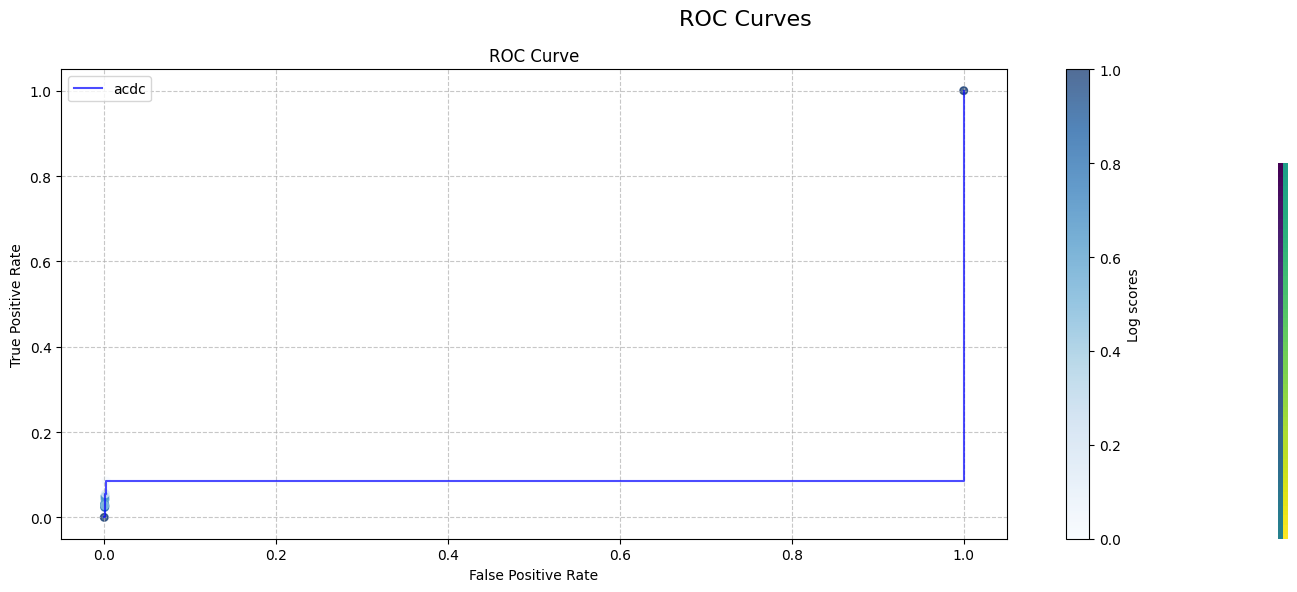

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

def discard_non_pareto_optimal(points, cmp="gt"):
    ret = []
    for x, y in points:
        for x1, y1 in points:
            if x1 < x and getattr(y1, f"__{cmp}__")(y) and (x1, y1) != (x, y):
                break
        else:
            ret.append((x, y))
    return list(sorted(ret))

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})
fig.suptitle("ROC Curves", fontsize=16)

colorscales = {
    "ACDC": "Blues",
}

for i, alg in enumerate(["ACDC"]):
    this_data = all_data["trained"]["random_ablation"]["hybrid-retrieval"]["kl_div"][alg]
    x_data = this_data["edge_fpr"]
    y_data = this_data["edge_tpr"]
    scores = this_data["score"]

    log_scores = np.log10(scores)
    log_scores = np.nan_to_num(log_scores, nan=0.0, neginf=0.0, posinf=0.0)

    min_score = np.min(log_scores)
    max_score = np.max(log_scores)

    normalized_scores = (log_scores - min_score) / (max_score - min_score)
    normalized_scores[~np.isfinite(normalized_scores)] = 0.0

    points = list(zip(x_data, y_data))
    pareto_optimal = discard_non_pareto_optimal(points)

    methodof = "acdc"

    pareto_x_data, pareto_y_data = zip(*pareto_optimal)
    
    # Plot Pareto optimal line
    ax1.step(pareto_x_data, pareto_y_data, where='post', label=methodof, color='blue', alpha=0.7)

    # Plot scatter points
    scatter = ax1.scatter(x_data, y_data, c=normalized_scores, cmap=colorscales[alg], s=30, alpha=0.7)

    # Color bar
    plt.colorbar(scatter, ax=ax1, label='Log scores')

# Configure main plot
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Create heatmap in the second subplot
nums = np.arange(200).reshape(2, 100).T.astype(float)
nums[:20, :20] = np.nan
heatmap = ax2.imshow(nums, cmap='viridis')
ax2.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()